In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/vamsidharsivakumar/dataset/dataset.xlsx


In [2]:
# Imports
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Import Distance Matrix 
df_distance = pd.read_excel('../input/d/vamsidharsivakumar/dataset/dataset.xlsx', index_col = 0)

# Transform to Numpy Array
distance_matrix = df_distance.to_numpy()

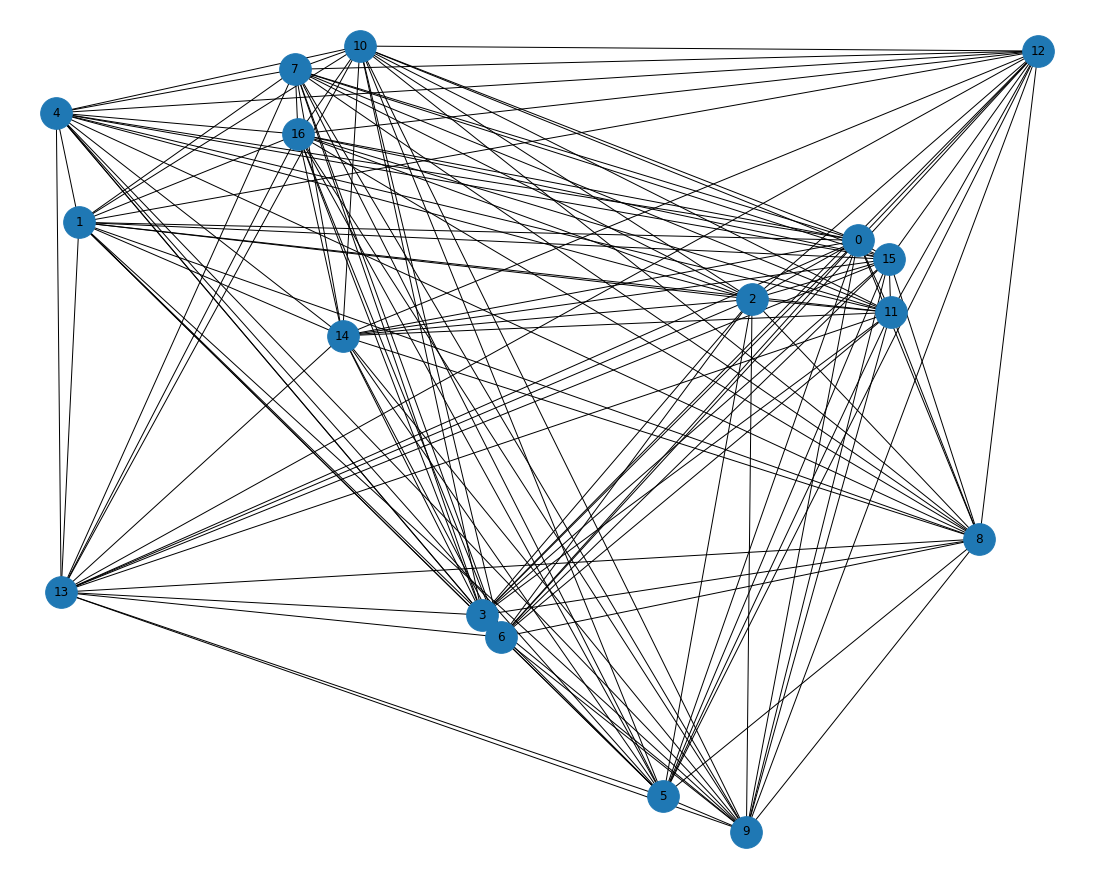

In [4]:
# Visualization of the distance matrix
G = nx.from_numpy_matrix(distance_matrix)

fig = plt.figure(1, figsize = (15, 12))
nx.draw(G, with_labels = True, font_weight = 'normal', node_size = 1000)

In [5]:
# Create dictionnary with data
data = {}
data['distance_matrix'] = distance_matrix
print("{:,} destinations".format(len(data['distance_matrix'][0]) - 1))

# Orders quantity (Water Cans)
data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
# Vehicles Capacities (Water Cans)
data['vehicle_capacities'] = [15, 15, 15, 15, 15, 15]
# Fleet informations
# Number of vehicles
data['num_vehicles'] = 6
# Location of the depot
data['depot'] = 0

16 destinations


In [6]:
def distance(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

In [7]:
def demand(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

In [8]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback.
transit_callback_index = routing.RegisterTransitCallback(distance)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint.
demand_callback_index = routing.RegisterUnaryTransitCallback(demand)
routing.AddDimensionWithVehicleCapacity(demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [9]:
if solution:
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for driver {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Water Cans({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Water Cans({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {} (m)\n'.format(route_distance)
        plan_output += 'Cargo Delivered: {} (Water Cans)\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {:,} (m)'.format(total_distance))
    print('Water Cans Delivered: {:,}/{:,}'.format(total_load, sum(data['demands'])))
else:
    print('No Solution')

Route for driver 0:
 0 Water Cans(0) ->  9 Water Cans(1) ->  10 Water Cans(3) ->  16 Water Cans(11) ->  14 Water Cans(15) ->  0 Water Cans(15)
Distance of the route: 15520 (m)
Cargo Delivered: 15 (Water Cans)

Route for driver 1:
 0 Water Cans(0) ->  12 Water Cans(2) ->  11 Water Cans(3) ->  15 Water Cans(11) ->  13 Water Cans(15) ->  0 Water Cans(15)
Distance of the route: 15520 (m)
Cargo Delivered: 15 (Water Cans)

Route for driver 2:
 0 Water Cans(0) ->  0 Water Cans(0)
Distance of the route: 0 (m)
Cargo Delivered: 0 (Water Cans)

Route for driver 3:
 0 Water Cans(0) ->  7 Water Cans(8) ->  1 Water Cans(9) ->  3 Water Cans(11) ->  4 Water Cans(15) ->  0 Water Cans(15)
Distance of the route: 15520 (m)
Cargo Delivered: 15 (Water Cans)

Route for driver 4:
 0 Water Cans(0) ->  0 Water Cans(0)
Distance of the route: 0 (m)
Cargo Delivered: 0 (Water Cans)

Route for driver 5:
 0 Water Cans(0) ->  8 Water Cans(8) ->  2 Water Cans(9) ->  6 Water Cans(13) ->  5 Water Cans(15) ->  0 Water Can

In [10]:
# Visualizations of the given routes

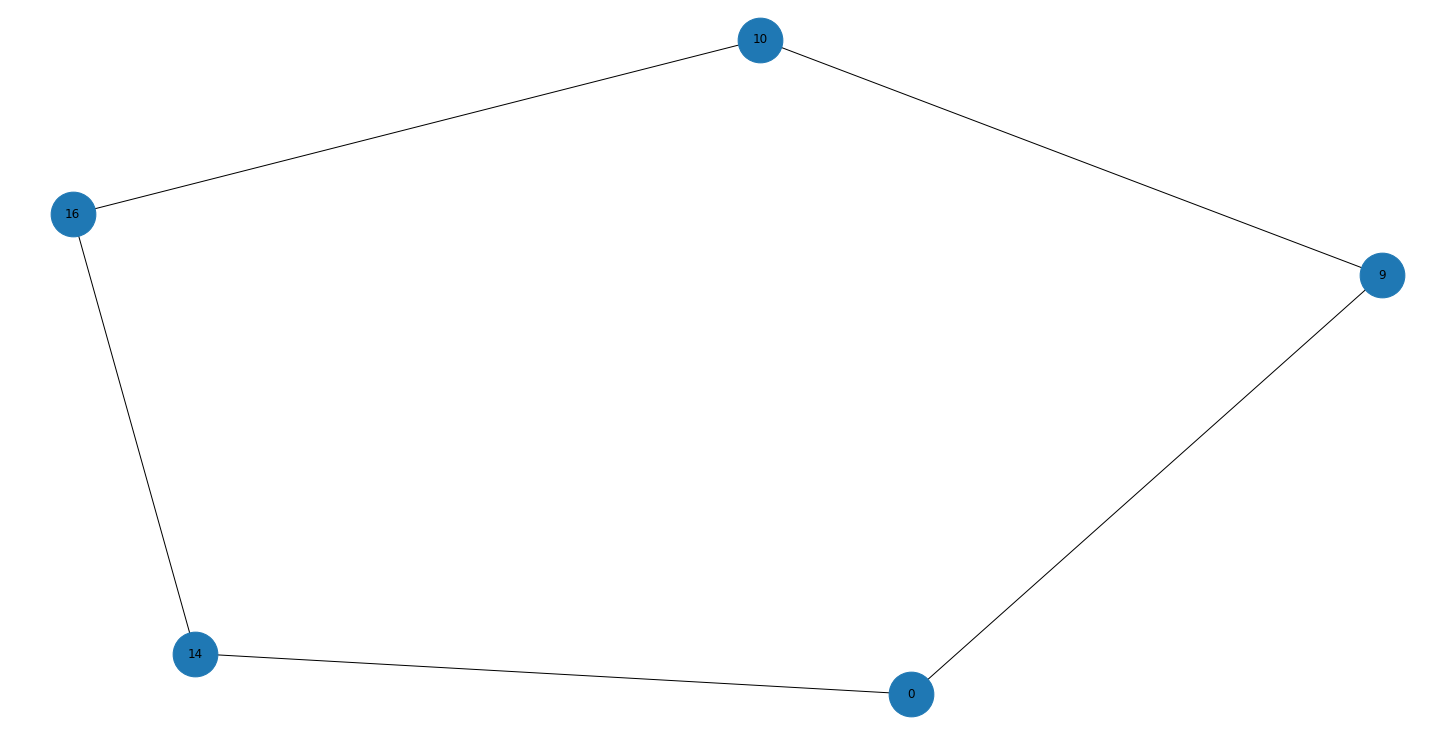

In [11]:
# For Driver 0 (0 -> 9 -> 10 -> 16 -> 14 -> 0)

df_distance1 = pd.read_excel('../input/d/vamsidharsivakumar/dataset/dataset.xlsx', index_col = 0)
distance_matrix1 = df_distance1.to_numpy()
G = nx.from_numpy_matrix(distance_matrix1)

ebunch = [(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 15),
 (0, 16),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (11, 12),
 (11, 13),
 (11, 14),
 (11, 15),
 (11, 16),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (13, 14),
 (13, 15),
 (13, 16),
 (14, 15),
 (15, 16)]

G.remove_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15])

G.remove_edges_from(ebunch)

fig = plt.figure(1, figsize = (20, 10))
nx.draw(G, with_labels = True, font_weight = 'normal', node_size = 2000)

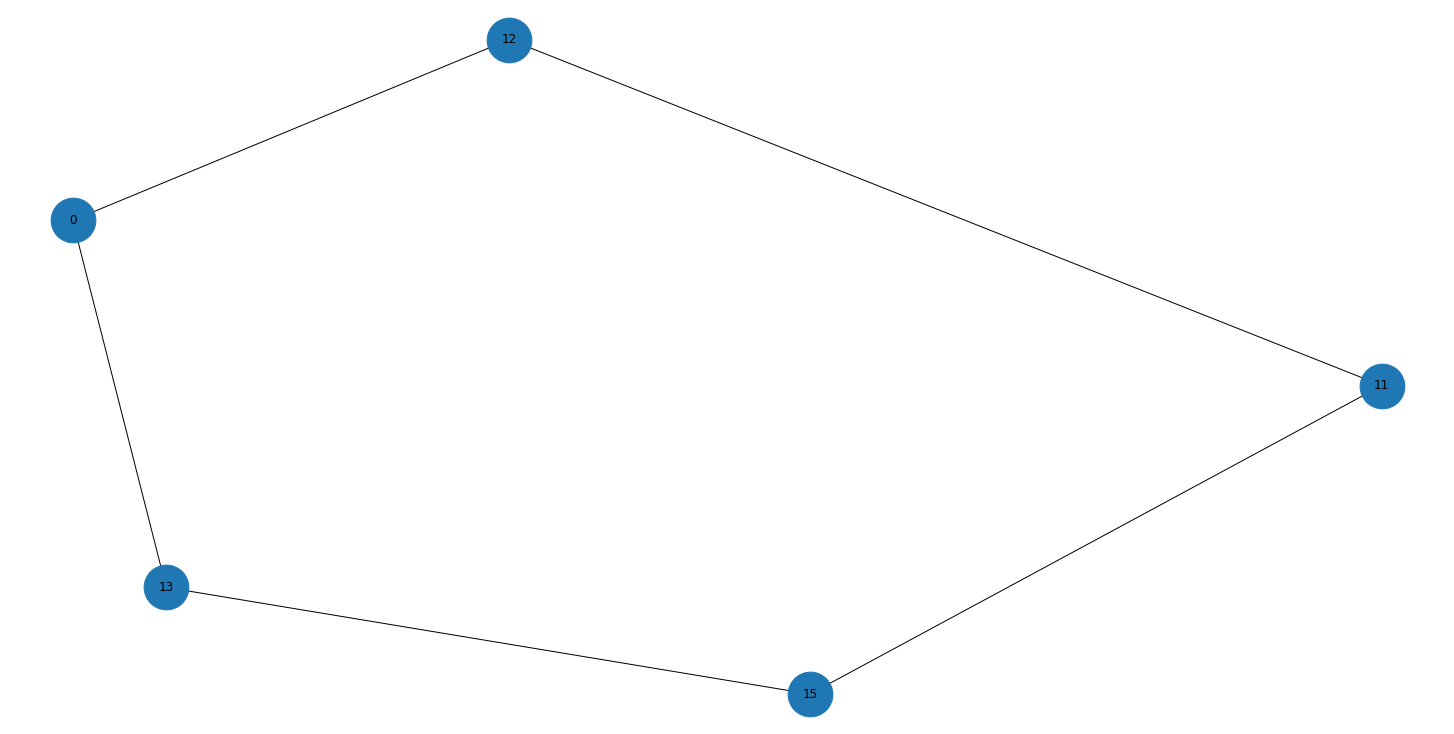

In [12]:
# For Driver 1 (0 -> 12 -> 11 -> 15 -> 13 -> 0)

df_distance2 = pd.read_excel('../input/d/vamsidharsivakumar/dataset/dataset.xlsx', index_col = 0)
distance_matrix2 = df_distance2.to_numpy()
G = nx.from_numpy_matrix(distance_matrix2)

ebunch = [(0, 1),
 (0, 2),
 (0, 3),
 (0, 5),
 (0, 6),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 15),
 (0, 16),
 (1, 2),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (11, 13),
 (11, 14),
 (11, 16),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (13, 14),
 (13, 16),
 (14, 15),
 (15, 16)]

G.remove_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16])

G.remove_edges_from(ebunch)

fig = plt.figure(1, figsize = (20, 10))
nx.draw(G, with_labels = True, font_weight = 'normal', node_size = 2000)

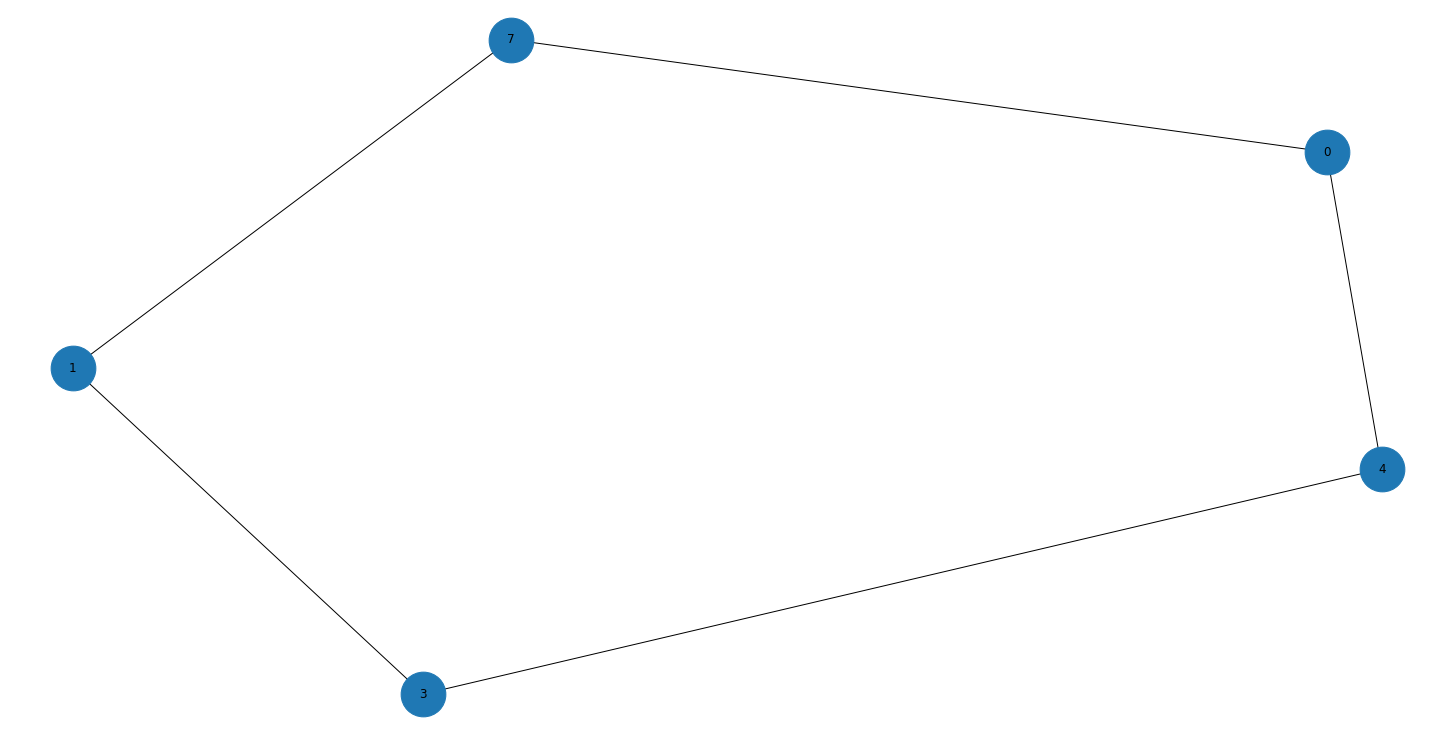

In [13]:
# For Driver 3 (0 -> 7 -> 1 -> 3 -> 4 -> 0)

df_distance3 = pd.read_excel('../input/d/vamsidharsivakumar/dataset/dataset.xlsx', index_col = 0)
distance_matrix3 = df_distance3.to_numpy()
G = nx.from_numpy_matrix(distance_matrix3)

ebunch = [(0, 1),
 (0, 2),
 (0, 3),
 (0, 5),
 (0, 6),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 15),
 (0, 16),
 (1, 2),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (11, 12),
 (11, 13),
 (11, 14),
 (11, 15),
 (11, 16),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (13, 14),
 (13, 15),
 (13, 16),
 (14, 15),
 (15, 16)]

G.remove_nodes_from([2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16])

G.remove_edges_from(ebunch)

fig = plt.figure(1, figsize = (20, 10))
nx.draw(G, with_labels = True, font_weight = 'normal', node_size = 2000)

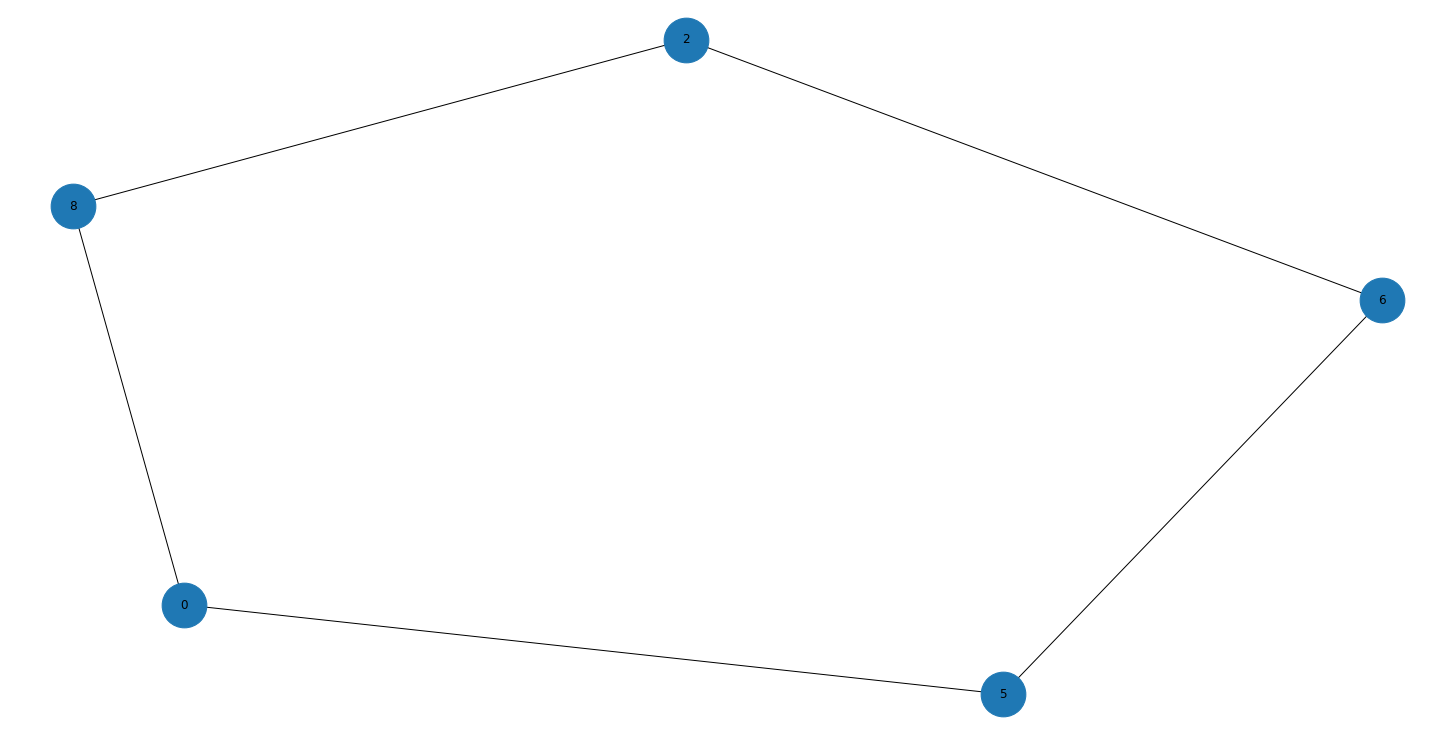

In [14]:
# For Driver 5 (0 -> 8 -> 2 -> 6 -> 5 -> 0)

df_distance3 = pd.read_excel('../input/d/vamsidharsivakumar/dataset/dataset.xlsx', index_col = 0)
distance_matrix3 = df_distance3.to_numpy()
G = nx.from_numpy_matrix(distance_matrix3)

ebunch = [(0, 1),
 (0, 2),
 (0, 3),
 (0, 6),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 15),
 (0, 16),
 (1, 2),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 7),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (9, 11),
 (9, 12),
 (9, 13),
 (9, 14),
 (9, 15),
 (9, 16),
 (10, 11),
 (10, 12),
 (10, 13),
 (10, 14),
 (10, 15),
 (11, 12),
 (11, 13),
 (11, 14),
 (11, 15),
 (11, 16),
 (12, 13),
 (12, 14),
 (12, 15),
 (12, 16),
 (13, 14),
 (13, 15),
 (13, 16),
 (14, 15),
 (15, 16)]

G.remove_nodes_from([1, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15, 16])

G.remove_edges_from(ebunch)

fig = plt.figure(1, figsize = (20, 10))
nx.draw(G, with_labels = True, font_weight = 'normal', node_size = 2000)